In [1]:
# uni_D83AE5_uni (Baseline)
#   {"Logloss": 0.023870107877615163, "ROCAUC": 0.9824492154273887}
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import gamma, kstest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    log_loss, 
    roc_auc_score, 
    roc_curve, 
    auc
)
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')  # Use this line to suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

training_data = pd.read_csv('/kaggle/input/lili-dataset/training_data.csv')
training_data = training_data[training_data['BORROWER_ID'] != 'xNullx']
training_data = training_data.sample(frac=1, random_state=42).reset_index(drop=True)
data_submission_example = pd.read_csv('/kaggle/input/lili-dataset/data_submission_example.csv')

lognormal_variables = [
    'CONTRACT_CREDIT_LOSS', 'CONTRACT_DEPT_SERVICE_TO_INCOME',
    'CONTRACT_INCOME', 'CONTRACT_INSTALMENT_AMOUNT', 'CONTRACT_INSTALMENT_AMOUNT_2',
    'CONTRACT_LOAN_AMOUNT', 'CONTRACT_MARKET_VALUE', 'CONTRACT_MORTGAGE_LENDING_VALUE', 
    'CONTRACT_LGD', 'CONTRACT_INCOME'
]

In [2]:
# # ADDITION 1
# import pandas as pd
# import numpy as np
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# numeric_columns = training_data.select_dtypes(include=[np.number]).columns.tolist()
# excluded_keywords = ['TARGET', 'event', 'binary', 'DATE', 'DAYS', 'YEARS', 'MATURITY', 'DAY', 'BORROWER']

# X_columns = [col for col in numeric_columns if all(keyword.lower() not in col.lower() for keyword in excluded_keywords)]
# X_columns.remove('CONTRACT_TYPE_OF_INTEREST_REPAYMENT')
# X_columns.remove('CONTRACT_MORTGAGE_TYPE')
# df_copy = training_data.copy()
# print(df_copy.isna().sum().sum())
# min_values = []
# for i in X_columns:
#     if i in lognormal_variables:
#         min_values.append(1)
#     else:
#         min_values.append(-np.inf)
# imputer = IterativeImputer(max_iter=30, random_state=42, min_value=min_values,)
# imputed_values = imputer.fit_transform(df_copy[X_columns])

In [3]:
# # ADDITION 2
# imputed_df = pd.DataFrame(imputed_values, columns=X_columns)

# for col in X_columns:
#     if imputed_df[col].dtype == 'float64':
#         imputed_df[col] = imputed_df[col].astype('float32')
#     elif imputed_df[col].dtype == 'int64':
#         imputed_df[col] = imputed_df[col].astype('int32')

# training_data.update(imputed_df)

In [4]:
training_data.fillna(0, inplace=True)
for col in training_data.columns:
    try:
        training_data[col] = pd.to_numeric(training_data[col], errors='ignore')
    except:
        continue
training_data['TARGET_EVENT_BINARY'] = np.where(training_data['TARGET_EVENT'] == 'K', 1, 0)

In [5]:
training_data.isna().sum()

CONTRACT_ID                            0
BORROWER_ID                            0
CONTRACT_BANK_ID                       0
CONTRACT_CREDIT_INTERMEDIARY           0
CONTRACT_CREDIT_LOSS                   0
CONTRACT_CURRENCY                      0
CONTRACT_DATE_OF_LOAN_AGREEMENT        0
CONTRACT_DEPT_SERVICE_TO_INCOME        0
CONTRACT_FREQUENCY_TYPE                0
CONTRACT_INCOME                        0
CONTRACT_INSTALMENT_AMOUNT             0
CONTRACT_INSTALMENT_AMOUNT_2           0
CONTRACT_INTEREST_PERIOD               0
CONTRACT_INTEREST_RATE                 0
CONTRACT_LGD                           0
CONTRACT_LOAN_AMOUNT                   0
CONTRACT_LOAN_CONTRACT_TYPE            0
CONTRACT_LOAN_TO_VALUE_RATIO           0
CONTRACT_LOAN_TYPE                     0
CONTRACT_MARKET_VALUE                  0
CONTRACT_MATURITY_DATE                 0
CONTRACT_MORTGAGE_LENDING_VALUE        0
CONTRACT_MORTGAGE_TYPE                 0
CONTRACT_REFINANCED                    0
CONTRACT_RISK_WE

In [6]:
training_data['TARGET_EVENT_E'] = np.where(training_data['TARGET_EVENT'] == 'E', 1, 0)

In [7]:
training_data['TARGET_EVENT_BINARY'].value_counts()

TARGET_EVENT_BINARY
0    1590792
1      10871
Name: count, dtype: int64

In [8]:

date_variables = ['CONTRACT_DATE_OF_LOAN_AGREEMENT', 'CONTRACT_MATURITY_DATE']

In [9]:
training_data['TARGET_EVENT_DAY'].replace(0.0, np.nan, inplace=True)
training_data['TARGET_EVENT_DAY_JULIAN'] = pd.to_datetime(training_data['TARGET_EVENT_DAY'], origin='julian', unit='D', errors='coerce')
training_data['TARGET_EVENT_DAY_DATETIME'] = pd.to_datetime(training_data['TARGET_EVENT_DAY_JULIAN'],  errors='coerce')

training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] = pd.to_datetime(training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT'], origin='julian', unit='D')
training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] = pd.to_datetime(training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'],)

training_data['CONTRACT_MATURITY_DATE_JULIAN'] = pd.to_datetime(training_data['CONTRACT_MATURITY_DATE'], origin='julian', unit='D')
training_data['CONTRACT_MATURITY_DATE_DATETIME'] = pd.to_datetime(training_data['CONTRACT_MATURITY_DATE_JULIAN'])

In [10]:
training_data['DAY_DIFF'] = (training_data['TARGET_EVENT_DAY_DATETIME'] - training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days
training_data['DAYS_TO_END'] = (pd.Timestamp("2020-01-01")- training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days
training_data['YEARS_TO_END'] = training_data['DAYS_TO_END'] / 365
training_data['DAYS_TO_2018'] = (pd.Timestamp("2018-01-01")- training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME']).dt.days
training_data['YEARS_TO_2018'] = training_data['DAYS_TO_2018'] / 365
training_data['TIME_TO_MATURITY_DAYS'] = (training_data['CONTRACT_MATURITY_DATE']-training_data['CONTRACT_DATE_OF_LOAN_AGREEMENT'])
training_data['2020_OR_MATURITY'] = np.minimum(training_data['TIME_TO_MATURITY_DAYS'], training_data['DAYS_TO_END'])
training_data['2020_OR_MATURITY_YEARS'] = training_data['2020_OR_MATURITY'] / 365

In [11]:
def create_binary_target_column(dataframe, column_name, event, day_diff_upper_limit):
    dataframe[column_name] = np.where(
        (dataframe['TARGET_EVENT'] == event) & 
        (dataframe['DAY_DIFF'] <= day_diff_upper_limit) & 
        (dataframe['DAY_DIFF'] >= 0), 
        1, 
        0
    )

timeframes = {
    'TARGET_EVENT_BINARY_2Y': 730,
    'TARGET_EVENT_BINARY_1Y': 365,
    'TARGET_EVENT_BINARY_6M': 365//2,
}

for column_name, days in timeframes.items():
    create_binary_target_column(training_data, column_name, 'K', days)


# target_event_binary_columns = []
# for i in range(6):
#     start_day = 273 + i * 30
#     column_header = 'TARGET_EVENT_BINARY_' + str(start_day) + 'D'
#     training_data[column_header] = np.where(
#         (training_data['TARGET_EVENT'] == 'K') & 
#         (training_data['DAY_DIFF'] <= start_day) & 
#         (training_data['DAY_DIFF'] >= 0), 
#         1, 
#         0
#     )
#     target_event_binary_columns.append(column_header)

training_data.drop('DAY_DIFF', axis=1, inplace=True)

In [12]:
print(training_data['TARGET_EVENT_BINARY'].value_counts())
print(training_data['TARGET_EVENT_BINARY_2Y'].value_counts())
print(training_data['TARGET_EVENT_BINARY_1Y'].value_counts())
print(training_data['TARGET_EVENT_BINARY_6M'].value_counts())

TARGET_EVENT_BINARY
0    1590792
1      10871
Name: count, dtype: int64
TARGET_EVENT_BINARY_2Y
0    1591751
1       9912
Name: count, dtype: int64
TARGET_EVENT_BINARY_1Y
0    1596927
1       4736
Name: count, dtype: int64
TARGET_EVENT_BINARY_6M
0    1601267
1        396
Name: count, dtype: int64


In [13]:
numeric_columns = training_data.select_dtypes(include=[np.number]).columns.tolist()
excluded_keywords = ['TARGET', 'event', 'binary', 'DATE', 'DAYS', 'YEARS', 'MATURITY', 'DAY']

X_columns = [col for col in numeric_columns if all(keyword.lower() not in col.lower() for keyword in excluded_keywords)]
y_column = 'TARGET_EVENT_BINARY_2Y' 
X_columns

['CONTRACT_CREDIT_INTERMEDIARY',
 'CONTRACT_CREDIT_LOSS',
 'CONTRACT_CURRENCY',
 'CONTRACT_DEPT_SERVICE_TO_INCOME',
 'CONTRACT_INCOME',
 'CONTRACT_INSTALMENT_AMOUNT',
 'CONTRACT_INSTALMENT_AMOUNT_2',
 'CONTRACT_INTEREST_PERIOD',
 'CONTRACT_INTEREST_RATE',
 'CONTRACT_LGD',
 'CONTRACT_LOAN_AMOUNT',
 'CONTRACT_LOAN_CONTRACT_TYPE',
 'CONTRACT_LOAN_TO_VALUE_RATIO',
 'CONTRACT_MARKET_VALUE',
 'CONTRACT_MORTGAGE_LENDING_VALUE',
 'CONTRACT_MORTGAGE_TYPE',
 'CONTRACT_REFINANCED',
 'CONTRACT_RISK_WEIGHTED_ASSETS',
 'CONTRACT_TYPE_OF_INTEREST_REPAYMENT',
 'BORROWER_BIRTH_YEAR',
 'BORROWER_CITIZENSHIP',
 'BORROWER_COUNTRY',
 'BORROWER_COUNTY',
 'BORROWER_TYPE_OF_SETTLEMENT']

In [14]:
# import numpy as np
# import numpy_financial as npf
# import pandas as pd

# def calculate_monthly_payment(row):
#     annual_interest_rate = row['CONTRACT_INTEREST_RATE'] / 100  # Convert percentage to decimal
#     monthly_interest_rate = annual_interest_rate / 12
#     term_in_months = ((pd.to_datetime(row['CONTRACT_MATURITY_DATE_DATETIME'], format='%d/%m/%Y') - 
#                        pd.to_datetime(row['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'], format='%d/%m/%Y'))).days/30
#     principal = row['CONTRACT_LOAN_AMOUNT']
#     monthly_payment = npf.pmt(monthly_interest_rate, term_in_months, -principal)
#     return monthly_payment
# ADDITION 3:

# X_columns.append('TIME_TO_MATURITY_DAYS')

In [15]:
loan_type_dummies = pd.get_dummies(training_data['CONTRACT_LOAN_TYPE'], prefix='LOAN_TYPE', drop_first=True)
frequency_type_dummies = pd.get_dummies(training_data['CONTRACT_FREQUENCY_TYPE'], prefix='FREQ_TYPE', drop_first=True)
interest_type_dummies = pd.get_dummies(training_data['CONTRACT_TYPE_OF_INTEREST_REPAYMENT'], prefix='INTEREST_TYPE', drop_first=True)
mortgage_type_dummies =  pd.get_dummies(training_data['CONTRACT_MORTGAGE_TYPE'], prefix='MORTGAGE_TYPE', drop_first=True)

training_data = pd.concat([training_data, loan_type_dummies, frequency_type_dummies,interest_type_dummies,mortgage_type_dummies ], axis=1)

X_columns.extend(loan_type_dummies.columns)
X_columns.extend(frequency_type_dummies.columns)
X_columns.extend(interest_type_dummies.columns)
X_columns.extend(mortgage_type_dummies.columns)
# X_columns.remove('CONTRACT_LOAN_TYPE')
# X_columns.remove('CONTRACT_FREQUENCY_TYPE')
X_columns.remove('CONTRACT_TYPE_OF_INTEREST_REPAYMENT')
X_columns.remove('CONTRACT_MORTGAGE_TYPE')

In [16]:
# training_data.loc[training_data['BORROWER_CITIZENSHIP'] == 0, 'BORROWER_CITIZENSHIP'] = 98
# citizenship_type_dummies = pd.get_dummies(training_data['BORROWER_CITIZENSHIP'], prefix='CITIZENSHIP_TYPE', drop_first=True)
# training_data = pd.concat([training_data, citizenship_type_dummies ], axis=1)
# X_columns.extend(citizenship_type_dummies.columns)

In [17]:
training_data['BORROWER_LOAN_COUNT'] = training_data.groupby('BORROWER_ID')['BORROWER_ID'].transform('count')
training_data['LOAN_BORROWER_COUNT'] = training_data.groupby('CONTRACT_ID')['CONTRACT_ID'].transform('count')
training_data['TOTAL_LOAN_AMOUNT'] = training_data.groupby('BORROWER_ID')['CONTRACT_LOAN_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_1'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT_2'] = training_data.groupby('BORROWER_ID')['CONTRACT_INSTALMENT_AMOUNT_2'].transform('sum')
training_data['TOTAL_INSTALLMENT_AMOUNT'] = training_data['TOTAL_INSTALLMENT_AMOUNT_1'] + training_data['TOTAL_INSTALLMENT_AMOUNT_2']

X_columns.extend(['BORROWER_LOAN_COUNT', 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT','LOAN_BORROWER_COUNT'])
lognormal_variables.extend([ 'TOTAL_LOAN_AMOUNT','TOTAL_INSTALLMENT_AMOUNT'])

In [18]:
threshold = 0.85
correlation_matrix = training_data[X_columns].corr()
highly_correlated_set = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_set.add(colname)

X_columns = [col for col in X_columns if col not in highly_correlated_set]
print('Variables removed:', highly_correlated_set)

Variables removed: {'CONTRACT_REFINANCED', 'BORROWER_COUNTRY', 'FREQ_TYPE_2f88e16c'}


In [19]:
def default_percentage_generator_2016(df, percentage, target, random_sample=42):
    df_copy = df.copy()
    df_filtered = df_copy[df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']
    df_mean = df_filtered[target].mean()
    print(f"Mean in year {df_mean}")
    df_defautled = df_filtered[target].sum()
    df_not_defaulted = len(df_filtered) - df_defautled

    required_val = (df_defautled - percentage * len(df_filtered))/(percentage - 1)
    
    df_filtered_after = df_copy[df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01']
    df_filtered_after = df_filtered_after[df_filtered_after[target]==1] 
    print(len(df_filtered_after))
    print(required_val)
    required_val = min(int(required_val) ,len(df_filtered_after))
    df_filtered_after = df_filtered_after.sample(n=int(required_val),random_state=random_sample).reset_index(drop=True)

    df_filtered = pd.concat([df_filtered, df_filtered_after])

    return df_filtered

def default_percentage_generator_2016_maximal(df, percentage, target):
    df_copy = df.copy()

    defaulted = df_copy[(df_copy[target]==1) & (df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2018-01-01')]
    total_needed = len(defaulted) / percentage * 100 - len(defaulted)


    # print(len(defaulted))
    # print(total_needed)

    df_filtered_2016 = df_copy[(df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01')& (df_copy[target]==0)]
    # print(len(df_filtered_2016))
    # print(total_needed)
    max_needed = min(total_needed,len(df_filtered_2016))
    df_filtered_2016 = df_filtered_2016.sample(n=int(max_needed),random_state=42).reset_index(drop=True)

    extra_needed = total_needed - len(df_filtered_2016)

    df_filtered_after = df_copy[df_copy['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01']
    df_filtered_after = df_filtered_after[df_filtered_after[target]==0]
    df_filtered_after = df_filtered_after.sample(n=int(extra_needed),random_state=42).reset_index(drop=True)


    df_filtered = pd.concat([df_filtered_2016, df_filtered_after,defaulted])

    return df_filtered

# default_percentage_generator_2016_maximal(training_data, 1.48, 'TARGET_EVENT_BINARY')['TARGET_EVENT_BINARY'].mean()


In [20]:
def calculate_probabilities(data, column, time_factor):
    lambdas = -np.log(1 - data[column]) / time_factor
    probs_2y = 1 - np.exp(-2 * lambdas)
    return probs_2y
def calculate_probabilities_vec(data, time_factor):
    lambdas = -np.log(1 - data) / time_factor
    probs_2y = 1 - np.exp(-2 * lambdas)
    return probs_2y


In [21]:
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import brier_score_loss




def train_and_predict_two_halves(df, variables, target, model=LogisticRegression(), 
                                 scaler=StandardScaler(), augment_distribution=True,calibrate=True,
                                 augment_distribution_percentage = 1.48, unique_loans=False,
                                 should_smote =False,maximal_sample=False,random_sample=42, 
                                 show_curve=False, calib_method = 'isotonic', cv_validate=False):
    if lognormal_variables is not None:
        df = df.copy()
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])
    if augment_distribution and not maximal_sample:
        df_filtered = default_percentage_generator_2016(df, augment_distribution_percentage/100, target, random_sample)
    else:
        df_filtered = df[df['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01']
    
    if maximal_sample:
        df_filtered = default_percentage_generator_2016_maximal(df, augment_distribution_percentage, target)
        print(df_filtered[target].mean())

    if unique_loans:
        df_filtered = df_filtered.drop_duplicates(subset=['CONTRACT_ID'])

    
    X_scaled = scaler.fit_transform(df[variables])
    X_filtered = scaler.transform(df_filtered[variables])

    y = df[target] 
    y_filtered = df_filtered[target] 
    if should_smote:
        smote = SMOTE(random_state=42)
        X_filtered, y_filtered = smote.fit_resample(X_filtered, y_filtered)

    if calibrate:
        model = CalibratedClassifierCV(base_estimator=model, method=calib_method, )

    
    cv_predictions_filtered = cross_val_predict(model, X_filtered, y_filtered, cv=5, method='predict_proba')
    df_filtered['cv_pred'] = cv_predictions_filtered[:, 1]  # Assuming binary classification

    model.fit(X_filtered, y_filtered)


    print("Logloss:")
    test_proba = model.predict_proba(X_filtered)
    print(log_loss(y_filtered,test_proba))
    print("Logloss CV (Should be main metric):")
    print(log_loss(y_filtered,cv_predictions_filtered))
    brier_score = brier_score_loss(y_filtered, cv_predictions_filtered[:,1])
    print(f"Brier Score: {brier_score}")
    proba = model.predict_proba(X_scaled)[:, 1]
    df['model_pred'] = proba
    print('Model mean on all data:', df['model_pred'].mean())

    combined_df = df.merge(df_filtered[['CONTRACT_ID', 'BORROWER_ID', 'cv_pred']], 
                        on=['CONTRACT_ID', 'BORROWER_ID'], 
                        how='left')

    # Replace predictions in df with those from cross-validation where available
    combined_df.loc[combined_df.cv_pred.notna(), 'model_pred'] = combined_df.cv_pred
    print('Moddel mean on CV combined:', combined_df['model_pred'].mean())
    roc_auc = roc_auc_score(y_filtered,test_proba[:,1])
    print("ROC AUC Score:", roc_auc)
    roc_auc = roc_auc_score(y_filtered,cv_predictions_filtered[:,1])
    print("ROC AUC Score CV (should be main metric):", roc_auc)

    if show_curve:
        true_probas, predicted_probas = calibration_curve(y_filtered, test_proba[:, 1], n_bins=10)
        plt.figure(figsize=(8, 6))
        plt.plot(predicted_probas, true_probas, marker='o')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfect calibration line
        plt.xlabel('Mean Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.title('Calibration Curve')
        plt.show()
    
    
    return combined_df['model_pred'], model


In [22]:
def significant_features(df, variables, target, model1=LogisticRegression(), scaler=StandardScaler()):
    if lognormal_variables is not None:
        df = df.copy()
        print(df[variables].isna().sum().sum())
        
        for var in lognormal_variables:
            if var == 'CONTRACT_CREDIT_LOSS':
                df[var] = np.log1p(np.abs(df[var]))*np.sign(df[var])
            else:
                df[var] = np.log1p(df[var])
    print(np.isinf(df[variables]).sum().sum())
    X_scaled = scaler.fit_transform(df[variables])
    print(np.isinf(X_scaled).sum().sum())
    print(pd.DataFrame(X_scaled, columns=variables).isna().sum().sum())
    X = sm.add_constant(pd.DataFrame(X_scaled, columns=variables))
    y = df[target]
    model = sm.Logit(y, X).fit()
    print(model.summary())
    p_values = model.pvalues
    non_significant_vars = p_values[p_values > 0.05].index.tolist()

    return model, non_significant_vars

In [23]:
def combined_probability(s):
    if len(s) == 2:
        p_a, p_b = s.values
        return p_a + p_b - p_a * p_b #- (-3.2357827075016176e-05)
    else:
        return 1 - np.prod(1 - s.values)

def create_submission_file(df_preds, target, example, filename='submission.csv', testing=False):
    # Filter the data to only include BORROWER_IDs that are in the submission example
    df_preds.loc[df_preds['TARGET_EVENT'] == 'E', target] = 0

    print("Logloss:")
    print(log_loss(df_preds['TARGET_EVENT_BINARY'], df_preds[target]))

    filtered_training_data = df_preds[df_preds['BORROWER_ID'].isin(example['BORROWER_ID'])]

    # Print warning if the row count is off
    if not testing and len(filtered_training_data) != 1564601:
        print('WARNING: The filtered data does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
    # Group by BORROWER_ID and calculate the combined probability

    #######################x########################
    #CUTTING TAILS DID NOT SEEM TO WORK
    #######################x########################
    # filtered_training_data = cut_exponential_tails(filtered_training_data, target)
    grouped_data = filtered_training_data.groupby('BORROWER_ID')[target].apply(combined_probability).reset_index()

    # Create the submission DataFrame
    df_submission = pd.DataFrame()
    df_submission['BORROWER_ID'] = grouped_data['BORROWER_ID']
    df_submission['PRED'] = grouped_data[target]
    print('Before centering:')
    print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())

    print('Centering probabilities...')
    # Center the probabilities around 1.48%
    desired_mean = 0.0148  # 1.48% as a decimal
    # while (df_submission['PRED'].max() > 1 or df_submission['PRED'].min() < 0 or abs(df_submission['PRED'].mean() -0.0148) > 0.0005):
    #     # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
    #     df_submission['PRED'] = df_submission['PRED'].clip(lower=0, upper=1)
    #     # print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())

    #     current_mean = df_submission['PRED'].mean()
    #     adjustment_factor = desired_mean  - current_mean
    #     df_submission['PRED'] += adjustment_factor
    initial_guess = 2
    probas_unscaled = df_submission['PRED'].values
    new_proba = probas_unscaled.copy()
    while abs(new_proba.mean() - desired_mean) > 0.00001:
        
        new_proba = calculate_probabilities_vec(probas_unscaled, initial_guess)
        error = new_proba.mean() - desired_mean
        if error > 0:
            initial_guess += 0.001
        else:
            initial_guess -= 0.001
        print(error, initial_guess)
    
    while abs(new_proba.mean() - desired_mean) > 0.000001:
        
        new_proba = calculate_probabilities_vec(probas_unscaled, initial_guess)
        error = new_proba.mean() - desired_mean
        if error > 0:
            initial_guess += 0.0001
        else:
            initial_guess -= 0.0001
        print(error, initial_guess)

    while abs(new_proba.mean() - desired_mean) > 0.0000001:
        
        new_proba = calculate_probabilities_vec(probas_unscaled, initial_guess)
        error = new_proba.mean() - desired_mean
        if error > 0:
            initial_guess += 0.00001
        else:
            initial_guess -= 0.00001
        print(error, initial_guess)
    df_submission['PRED'] = new_proba
        
        
    
    print(df_submission['PRED'].max(), df_submission['PRED'].min(), df_submission['PRED'].mean())
    # Save the submission file
    if  not testing and filename is not None:
        df_submission.to_csv(filename, index=False)
    print(f'Saved file: {filename}')
    # if abs(df_submission['PRED'].mean() -0.0148) > 0.0005:
    #    raise ValueError('WARNING: mean is bad')
        
    # Print warning if the row count is off
    if not testing and len(df_submission) != 1117674:
        print('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        # raise ValueError('WARNING: The submission file does not have the correct number of rows. Make sure you are not using the training data for submission.')
        
    return df_submission


In [24]:
def test_model_2y_1y(df, variables, target, model1=LogisticRegression(), model2=LogisticRegression()):
    df = df.copy()
    start_date = pd.Timestamp('2015-01-01')
    end_date = pd.Timestamp('2017-01-01')

    # Mask for rows with CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN between start_date and end_date
    mask_date_range = (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] >= start_date) & (df['CONTRACT_DATE_OF_LOAN_AGREEMENT_JULIAN'] <= end_date)

    df = df[mask_date_range]

    probs = train_and_predict_two_halves(
        df, 
        variables, 
        target, 
        model1=model1,
        model2=model2,
    )
    df['2Y-1Y-PROBS'] = probs
    
    test_data = pd.read_csv('./data/1y-test.csv')


    df_submission = create_submission_file(df, '2Y-1Y-PROBS', test_data, filename=None, testing=True)

    merged_df = pd.merge(test_data, df_submission, on='BORROWER_ID')
    true_labels = merged_df['TARGET_EVENT_BINARY_1Y']
    predicted_probs = merged_df['PRED']
    logloss = log_loss(true_labels, predicted_probs)

    print(f'Log loss: {logloss}')
        
    return logloss

In [25]:
def scale_yearly_proba(data, proba, targets =[ 0.0052, 0.0099, 0.0185], logging=False):
    data = data.copy()
    probs = data[proba]
    starter_scales=[2.8, 1.2, 0.75]
    new_proba = np.zeros(len(data))
    mask_2016 = (data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2016-01-01') & (data['TARGET_EVENT_BINARY'] != 1)
    mask_2017 = (data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2016-01-01') & (data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] < '2017-01-01')& (data['TARGET_EVENT_BINARY'] != 1)
    mask_2018 = (data['CONTRACT_DATE_OF_LOAN_AGREEMENT_DATETIME'] > '2017-01-01') & (data['TARGET_EVENT_BINARY'] != 1)

    proba_2016 = probs
    proba_2017 = probs
    proba_2018 = probs
    if logging:
        print("Before scaling:")
        print(proba_2016[mask_2016].mean(), proba_2017[mask_2017].mean(), proba_2018[mask_2018].mean())
        print(probs.mean())
    calib_2016 = True
    calib_2017 = True
    calib_2018 = True

    while calib_2016 or calib_2017 or calib_2018:    
        proba_2016 = probs
        proba_2017 = probs
        proba_2018 = probs
        proba_2016 = calculate_probabilities_vec(proba_2016, starter_scales[0])
        proba_2017 = calculate_probabilities_vec(proba_2017, starter_scales[1])
        proba_2018 = calculate_probabilities_vec(proba_2018, starter_scales[2])
        
        new_proba[mask_2016] = proba_2016[mask_2016]
        new_proba[mask_2017] = proba_2017[mask_2017]
        new_proba[mask_2018] = proba_2018[mask_2018]
        if logging:
            print('Adter scaling:')
            print(proba_2016[mask_2016].mean(), proba_2017[mask_2017].mean(), proba_2018[mask_2018].mean())
            print(new_proba.mean())

        mean_2016 = proba_2016[mask_2016].mean()
        mean_2017 = proba_2017[mask_2017].mean()
        mean_2018 = proba_2018[mask_2018].mean()

        diff_2016 = mean_2016 - targets[0]
        diff_2017 = mean_2017 - targets[1]
        diff_2018 = mean_2018 - targets[2]
        if diff_2016 > 0.0001:
            starter_scales[0] += 0.01
        elif diff_2016 < -0.0001:
            starter_scales[0] -= 0.01
        else:
            calib_2016 = False
        if diff_2017 > 0.0001:
            starter_scales[1] += 0.01
        elif diff_2017 < -0.0001:
            starter_scales[1] -= 0.01
        else:
            calib_2017 = False
        if diff_2018 > 0.0001:
            starter_scales[2] += 0.01
        elif diff_2018 < -0.0001:
            starter_scales[2] -= 0.01
        else:
            calib_2018 = False
    return new_proba
    

In [26]:
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.014855
#          Iterations: 35
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601611
# Method:                               MLE   Df Model:                           51
# Date:                    Wed, 08 Nov 2023   Pseudo R-squ.:                  0.6053
# Time:                            17:03:09   Log-Likelihood:                -23792.
# converged:                          False   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000

#  No dummies and feature engineering:
# Optimization terminated successfully.
#          Current function value: 0.017321
#          Iterations 13
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601638
# Method:                               MLE   Df Model:                           24
# Date:                    Wed, 08 Nov 2023   Pseudo R-squ.:                  0.5398
# Time:                            20:38:24   Log-Likelihood:                -27743.
# converged:                           True   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000
# Two more variables added: LOAN_TYPE, FREQ_TYPE, MORGTAGE_TYPE, INTEREST_TYPE
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.014613
#          Iterations: 35
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601589
# Method:                               MLE   Df Model:                           73
# Date:                    Thu, 09 Nov 2023   Pseudo R-squ.:                  0.6118
# Time:                            18:28:24   Log-Likelihood:                -23405.
# converged:                          False   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000
# Adding monthly to LOAN_TYPE, FREQ_TYPE, MORGTAGE_TYPE, INTEREST_TYPE
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.014232
#          Iterations: 35
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601584
# Method:                               MLE   Df Model:                           78
# Date:                    Thu, 09 Nov 2023   Pseudo R-squ.:                  0.6219
# Time:                            18:35:37   Log-Likelihood:                -22795.
# converged:                          False   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000
#  ADDING TIME TO MATURITY in days
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.014143
#          Iterations: 35
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601586
# Method:                               MLE   Df Model:                           76
# Date:                    Mon, 13 Nov 2023   Pseudo R-squ.:                  0.6242
# Time:                            17:00:42   Log-Likelihood:                -22653.
# converged:                          False   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000
# Best score:
# Warning: Maximum number of iterations has been exceeded.
#          Current function value: 0.014634
#          Iterations: 35
#                              Logit Regression Results                             
# ==================================================================================
# Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
# Model:                              Logit   Df Residuals:                  1601605
# Method:                               MLE   Df Model:                           57
# Date:                    Mon, 27 Nov 2023   Pseudo R-squ.:                  0.6112
# Time:                            10:45:49   Log-Likelihood:                -23439.
# converged:                          False   LL-Null:                       -60284.
# Covariance Type:                nonrobust   LLR p-value:                     0.000



In [27]:
X_columns.remove('CONTRACT_CURRENCY')
X_columns.remove('BORROWER_COUNTY')
# X_columns.remove('CONTRACT_MORTGAGE_TYPE')
X_columns.remove('BORROWER_TYPE_OF_SETTLEMENT')
X_columns.remove('BORROWER_CITIZENSHIP')
X_columns.remove('LOAN_BORROWER_COUNT')


In [28]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    # https://stackoverflow.com/a/39813304/1956309
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data.columns[selector.get_support(indices=True)]
min_variance = 0.0001
low_variance = variance_threshold_selector(training_data[X_columns], min_variance) 

In [29]:
for i in X_columns:
    if i not in low_variance:
        print(i)

LOAN_TYPE_47693941
LOAN_TYPE_8fe006f1
LOAN_TYPE_cde77491
FREQ_TYPE_bd092d5a
MORTGAGE_TYPE_3.0
MORTGAGE_TYPE_10.0
MORTGAGE_TYPE_41.0
MORTGAGE_TYPE_42.0
MORTGAGE_TYPE_43.0
MORTGAGE_TYPE_47.0


In [30]:
X_columns = low_variance
X_columns= list(X_columns)
# X_columns.append('TIME_TO_MATURITY_DAYS')
# training_data['TIME_TO_MATURITY_DAYS_SQRT'] = np.sqrt(training_data['TIME_TO_MATURITY_DAYS'])
# X_columns.append('TIME_TO_MATURITY_DAYS_SQRT')

# training_data['MONTHLY_PAYMENT'] = training_data.apply(calculate_monthly_payment, axis=1)
# training_data['MONTHLY_PAYMENT'] = training_data['MONTHLY_PAYMENT'].apply(lambda x: 0 if not np.isfinite(x) else x)
# X_columns.extend(['MONTHLY_PAYMENT'])
# lognormal_variables.extend(['MONTHLY_PAYMENT'])

In [31]:
vals = training_data['CONTRACT_LOAN_TYPE'].value_counts() < 5000

In [32]:
small_list = vals.index[vals].tolist()
small_header = ['LOAN_TYPE_' + i for i in small_list]
print(small_header)
for i in small_header:
    if i in X_columns:
        print(i)
        X_columns.remove(i)

['LOAN_TYPE_694cbaee', 'LOAN_TYPE_0aeb4094', 'LOAN_TYPE_eab72d7a', 'LOAN_TYPE_95c4f8fb', 'LOAN_TYPE_f792971b', 'LOAN_TYPE_cde77491', 'LOAN_TYPE_47693941', 'LOAN_TYPE_8fe006f1']
LOAN_TYPE_694cbaee
LOAN_TYPE_eab72d7a
LOAN_TYPE_95c4f8fb
LOAN_TYPE_f792971b


In [33]:
# vals = training_data['CONTRACT_MORTGAGE_TYPE'].value_counts() < 5000
# small_list = vals.index[vals].tolist()
# small_header = ['MORTGAGE_TYPE_' + str(i) for i in small_list]
# print(small_header)
# for i in small_header:
#     if i in X_columns:
#         print(i)
#         X_columns.remove(i)

In [34]:
model, non_significant_vars = significant_features(training_data, X_columns, y_column,LogisticRegression())

0
0
0
0
         Current function value: 0.014681
         Iterations: 35
                             Logit Regression Results                             
Dep. Variable:     TARGET_EVENT_BINARY_2Y   No. Observations:              1601663
Model:                              Logit   Df Residuals:                  1601609
Method:                               MLE   Df Model:                           53
Date:                    Sat, 02 Dec 2023   Pseudo R-squ.:                  0.6099
Time:                            15:06:02   Log-Likelihood:                -23514.
converged:                          False   LL-Null:                       -60284.
Covariance Type:                nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             -10.1307      2.095     -4.8

In [35]:
non_significant_vars

['CONTRACT_INSTALMENT_AMOUNT',
 'CONTRACT_LOAN_AMOUNT',
 'MORTGAGE_TYPE_1.0',
 'MORTGAGE_TYPE_4.0',
 'MORTGAGE_TYPE_8.0',
 'MORTGAGE_TYPE_13.0',
 'MORTGAGE_TYPE_44.0',
 'MORTGAGE_TYPE_45.0',
 'MORTGAGE_TYPE_48.0']

Mean in year 0.011345816067598232
5206
2769.8234336859236
Logloss:
0.018505870651096466
Logloss CV (Should be main metric):
0.019714074418823054
Brier Score: 0.005954367990740607
Model mean on all data: 0.012787244
Moddel mean on CV combined: 0.012661173
ROC AUC Score: 0.996333831155409
ROC AUC Score CV (should be main metric): 0.9957919602217572
0.012661173


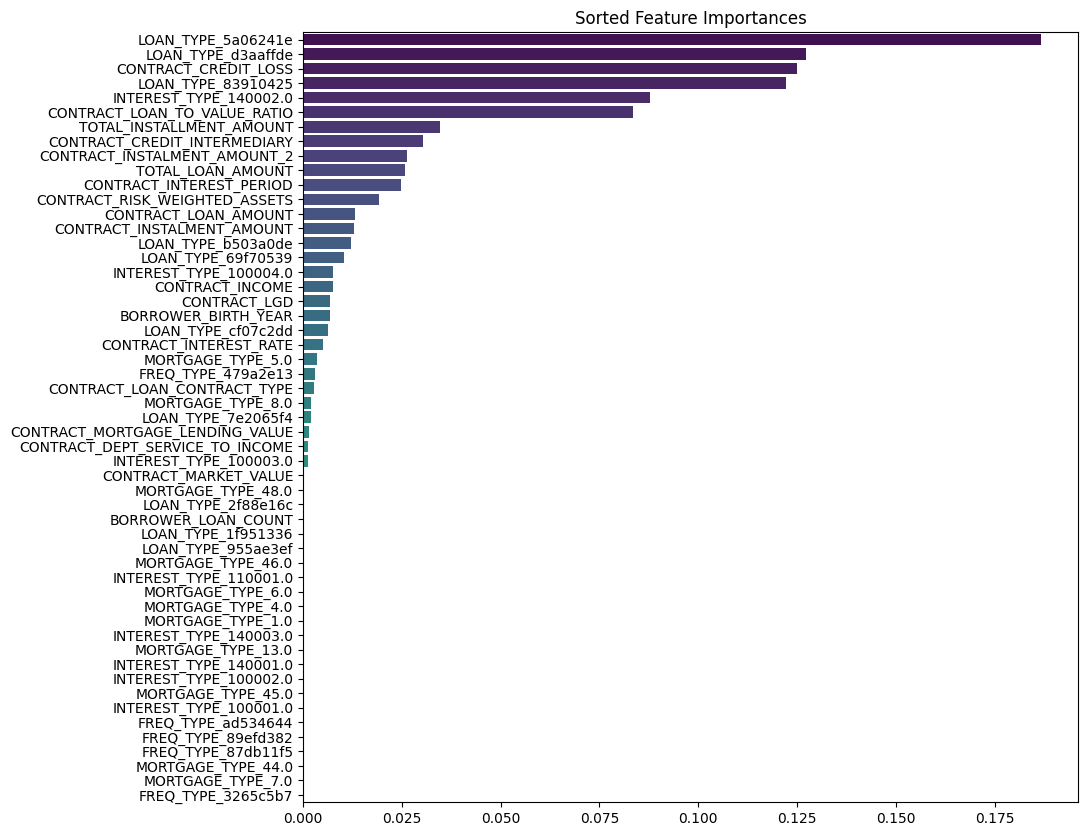

In [36]:
predicted_probs = 'XGB'
training_data['XGB_CUMM'] = 0
iterations = 1
for i in range(iterations):
    probs, xgb_model = train_and_predict_two_halves(
        training_data, 
        X_columns, 
        'TARGET_EVENT_BINARY',
        model=xgb.XGBClassifier(max_depth=2, n_estimators=70, random_state=42, use_label_encoder=False, eval_metric='logloss'),
        augment_distribution=True,
        augment_distribution_percentage=1.68,
        calibrate=False,
        random_sample=i,
        calib_method='isotonic',
        show_curve=False,
    )
    training_data[predicted_probs] = probs
    training_data['XGB_CUMM'] += probs
training_data['XGB_CUMM'] /= iterations
print(probs.mean())
# this helps
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'XGB'] = 0
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'XGB_CUMM'] = 0
feature_importances = xgb_model.feature_importances_
feature_names = X_columns

sorted_idx = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_idx]
sorted_feature_names = np.array(feature_names)[sorted_idx]

# Plot
plt.figure(figsize=(10, 10))
sns.barplot(x=sorted_feature_importances, y=sorted_feature_names, palette="viridis")
plt.title('Sorted Feature Importances')
plt.show()

In [37]:
feature_importances

array([0.03045885, 0.12510382, 0.00135181, 0.00746704, 0.01294755,
       0.02624006, 0.0247337 , 0.00503326, 0.00692283, 0.01301755,
       0.00281087, 0.08358486, 0.        , 0.00160537, 0.01929707,
       0.00684188, 0.        , 0.        , 0.18678755, 0.01043401,
       0.00187717, 0.12211774, 0.        , 0.01217185, 0.00638045,
       0.12728837, 0.        , 0.00297354, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00125077, 0.00763317,
       0.        , 0.        , 0.08783671, 0.        , 0.        ,
       0.        , 0.00339675, 0.        , 0.        , 0.00188248,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02588456, 0.03466828], dtype=float32)

In [38]:
zero_importance_features = np.array(feature_names)[feature_importances < 0.005]
zero_importance_features = list(zero_importance_features)
XGB_features = X_columns.copy()
for i in zero_importance_features:
    if i in XGB_features:
        print(i)
        XGB_features.remove(i)
print(len(XGB_features))

CONTRACT_DEPT_SERVICE_TO_INCOME
CONTRACT_LOAN_CONTRACT_TYPE
CONTRACT_MARKET_VALUE
CONTRACT_MORTGAGE_LENDING_VALUE
LOAN_TYPE_1f951336
LOAN_TYPE_2f88e16c
LOAN_TYPE_7e2065f4
LOAN_TYPE_955ae3ef
FREQ_TYPE_3265c5b7
FREQ_TYPE_479a2e13
FREQ_TYPE_87db11f5
FREQ_TYPE_89efd382
FREQ_TYPE_ad534644
INTEREST_TYPE_100001.0
INTEREST_TYPE_100002.0
INTEREST_TYPE_100003.0
INTEREST_TYPE_110001.0
INTEREST_TYPE_140001.0
INTEREST_TYPE_140003.0
MORTGAGE_TYPE_1.0
MORTGAGE_TYPE_4.0
MORTGAGE_TYPE_5.0
MORTGAGE_TYPE_6.0
MORTGAGE_TYPE_7.0
MORTGAGE_TYPE_8.0
MORTGAGE_TYPE_13.0
MORTGAGE_TYPE_44.0
MORTGAGE_TYPE_45.0
MORTGAGE_TYPE_46.0
MORTGAGE_TYPE_48.0
BORROWER_LOAN_COUNT
22


In [39]:
# X_columns.append('TIME_TO_MATURITY_DAYS')

Mean in year 0.011345816067598232
5206
2259.690510058932
Logloss:
0.025219498529387832
Logloss CV (Should be main metric):
0.025863071380099144
Brier Score: 0.007818715270283312
Model mean on all data: 0.015402183999425103
Moddel mean on CV combined: 0.015352479842552618
ROC AUC Score: 0.9885214370476803
ROC AUC Score CV (should be main metric): 0.987364177882159


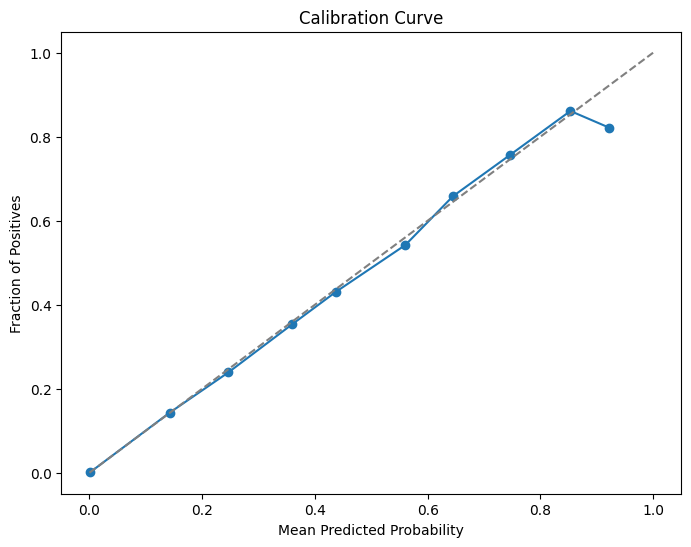

Mean in year 0.011345816067598232
5206
2259.690510058932
Logloss:
0.025059194839617084
Logloss CV (Should be main metric):
0.02572156108704739
Brier Score: 0.00778965795000582
Model mean on all data: 0.015333234878138986
Moddel mean on CV combined: 0.015276412073091534
ROC AUC Score: 0.9887564072476772
ROC AUC Score CV (should be main metric): 0.9876259144525052
Mean in year 0.011345816067598232
5206
2259.690510058932
Logloss:
0.024951271054731338
Logloss CV (Should be main metric):
0.02556982632108495
Brier Score: 0.00773876132478324
Model mean on all data: 0.0152994349287442
Moddel mean on CV combined: 0.015246265130276613
ROC AUC Score: 0.9885455964202394
ROC AUC Score CV (should be main metric): 0.987484920930487
Mean in year 0.011345816067598232
5206
2259.690510058932
Logloss:
0.025133521472531162
Logloss CV (Should be main metric):
0.025780819693365847
Brier Score: 0.007802365009504946
Model mean on all data: 0.015373579611823009
Moddel mean on CV combined: 0.015319136631979365
R

In [40]:
# Adding calib (isotonic)
# Logloss: 0.02385418586559387
# Logloss: imputed
# 0.02372888852503455
# Logloss: imputed and removed a few unnecessary variables
# 0.023720691340422
# Logloss: imouted and added monthly payment
# 0.02294559159914238
# Logloss: best sub:
# 0.023917118107561128
# Baseline 
# Logloss:
# 0.024713104586663846
# Logloss CV (Should be main metric):
# 0.02548903684028476 difference: 0.000775932253620914

# Logloss:
# 0.02388712253824945
# Logloss CV (Should be main metric):
# 0.0246367355763676
predicted_probs = 'LOGISTIC_REG'
training_data['LOGISTIC_REG_CUMM'] = 0
iterations = 10
for i in range(iterations):
    probs,_ = train_and_predict_two_halves(
        training_data, 
        XGB_features, 
        'TARGET_EVENT_BINARY',
        model=LogisticRegression(max_iter=400, random_state=i,solver='lbfgs'),
        augment_distribution=True,
        augment_distribution_percentage=1.58,
        calibrate=True,
        unique_loans=False,
        should_smote=False,
        maximal_sample=False,
        random_sample=i,
        calib_method='isotonic',
        show_curve=(i==0),
        cv_validate=True,
    )
    training_data[predicted_probs] = probs
    training_data['LOGISTIC_REG_CUMM'] += probs
training_data['LOGISTIC_REG_CUMM'] /= iterations
print(probs.mean())
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'LOGISTIC_REG'] = 0
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'LOGISTIC_REG_CUMM'] = 0

In [41]:
# 0.013758520786981003 this swas the start with around ll 239 
new_proba = scale_yearly_proba(training_data, 'LOGISTIC_REG')
print(new_proba.mean())
training_data['YEAR_SCALED_PROBA'] = new_proba
_ = create_submission_file(training_data, 'LOGISTIC_REG', data_submission_example, filename='lr_no_use.csv')
submission = create_submission_file(training_data, 'YEAR_SCALED_PROBA', data_submission_example, filename='lr.csv')

0.01152902817549479
Logloss:
0.022611948389619847
Before centering:
0.9999979048558122 6.230335503620843e-06 0.015153171167952976
Centering probabilities...
0.0003531711679529755 2.001
0.0003481034128522374 2.002
0.000343039134221932 2.0029999999999997
0.00033797832835041723 2.0039999999999996
0.0003329209915316853 2.0049999999999994
0.0003278671200652519 2.0059999999999993
0.0003228167102562324 2.0069999999999992
0.0003177697584151023 2.007999999999999
0.0003127262608580289 2.008999999999999
0.0003076862139065606 2.009999999999999
0.00030264961388776386 2.010999999999999
0.0002976164571341436 2.0119999999999987
0.00029258673998376963 2.0129999999999986
0.0002875604587800739 2.0139999999999985
0.0002825376098719544 2.0149999999999983
0.0002775181896137683 2.0159999999999982
0.0002725021943652591 2.016999999999998
0.00026748962049159657 2.017999999999998
0.0002624804643633939 2.018999999999998
0.00025747472235659354 2.019999999999998
0.000252472390852505 2.0209999999999977
0.00024747346

Mean in year 0.011345816067598232
5206
3793.2087240114124
Logloss:
0.015350682411339755
Logloss CV (Should be main metric):
0.01760000260361286
Brier Score: 0.005303873968868173
Model mean on all data: 0.012757361056614713
Moddel mean on CV combined: 0.012596289419443633
ROC AUC Score: 0.9979123957716736
ROC AUC Score CV (should be main metric): 0.9971061653139379


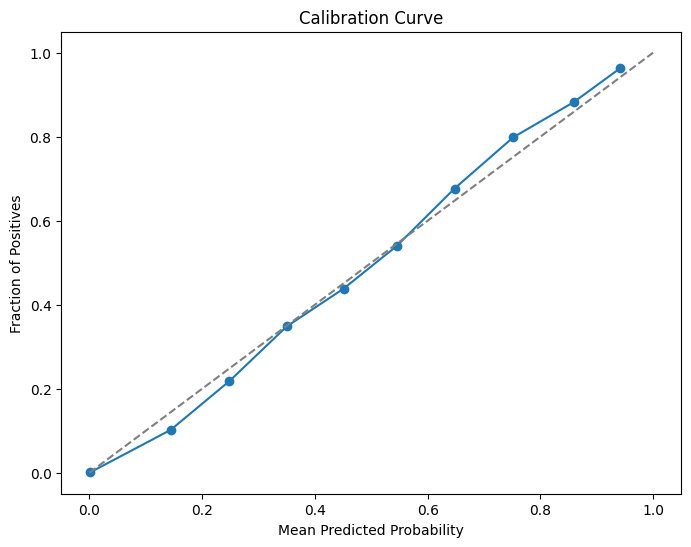

0.012596289419443633


In [42]:
# Logloss: 3/100  {"Logloss": 0.02464322859352732, "ROCAUC": 0.9811613911584315}
# Logloss CV (Should be main metric):
# 0.016490603765229917
# ------------------------------------------------------------------------------------
# Logloss: 3/80  {"Logloss":  0.024642222808864266, "ROCAUC": 0.9811391883860157}
# 0.015030705437515932 
# Brier Score: 0.005587692747635368
# ------------------------------------------------------------------------------------
# Logloss CV (Should be main metric):
# 0.01696407512691213
# {"Logloss": 0.024772367851076567, "ROCAUC": 0.9812963808838873} 5/80
# ------------------------------------------------------------------------------------
# Logloss CV (Should be main metric): 3/90
# 0.01833917716865919
# Brier Score: 0.005508349353520719
# ------------------------------------------------------------------------------------
predicted_probs = 'XGB'
training_data['XGB_CUMM'] = 0
iterations = 1
for i in range(iterations):
    probs, xgb_model = train_and_predict_two_halves(
        training_data, 
        XGB_features, 
        'TARGET_EVENT_BINARY',
        model=xgb.XGBClassifier(max_depth=3, n_estimators=90, random_state=42, use_label_encoder=False, eval_metric='logloss'),
        augment_distribution=True,
        augment_distribution_percentage=1.88,
        calibrate=True,
        random_sample=i,
        calib_method='isotonic',
        show_curve=(i==0),
    )
    training_data[predicted_probs] = probs
    training_data['XGB_CUMM'] += probs
training_data['XGB_CUMM'] /= iterations
print(probs.mean())
# this helps
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'XGB'] = 0
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'XGB_CUMM'] = 0
# Logloss CV (Should be main metric):
# 0.018356956238520378

In [43]:
_ = create_submission_file(training_data, 'XGB', data_submission_example, filename='xgb_no_use.csv')


Logloss:
0.016524424647495494
Before centering:
1.0 0.0 0.009645971247623513
Centering probabilities...
-0.0051540287523764855 1.999
-0.00515121693982999 1.9980000000000002
-0.0051484033061525054 1.9970000000000003
-0.0051455878493741995 1.9960000000000004
-0.005142770567522102 1.9950000000000006
-0.005139951458620135 1.9940000000000007
-0.005137130520689112 1.9930000000000008
-0.005134307751746709 1.9920000000000009
-0.005131483149807502 1.991000000000001
-0.0051286567128828835 1.990000000000001
-0.005125828438981159 1.9890000000000012
-0.005122998326107412 1.9880000000000013
-0.0051201663722636424 1.9870000000000014
-0.005117332575448656 1.9860000000000015
-0.005114496933658053 1.9850000000000017
-0.005111659444884304 1.9840000000000018
-0.005108820107116703 1.9830000000000019
-0.005105978918341315 1.982000000000002
-0.0051031358765410186 1.981000000000002
-0.005100290979695506 1.9800000000000022
-0.005097444225781242 1.9790000000000023
-0.005094595612771495 1.9780000000000024
-0.005

Mean in year 0.011345816067598232
5206
4306.467455621301
Logloss:
0.023053056223598004
Logloss CV (Should be main metric):
0.024533382552971352
Brier Score: 0.007668883011567052
Model mean on all data: 0.014430337405932338
Moddel mean on CV combined: 0.01433325632492792
ROC AUC Score: 0.9954634875245798
ROC AUC Score CV (should be main metric): 0.9947020627196991


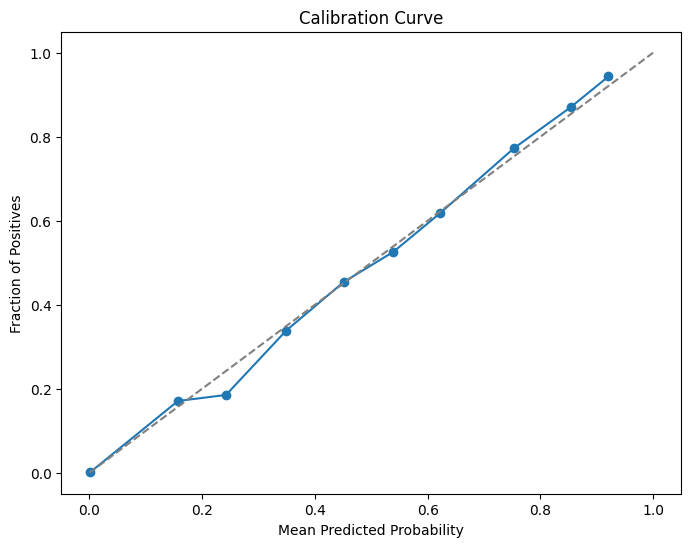

Mean in year 0.011345816067598232
5206
4306.467455621301
Logloss:
0.023061709715591492
Logloss CV (Should be main metric):
0.024547595871573773
Brier Score: 0.007668519725118872
Model mean on all data: 0.014450175286323506
Moddel mean on CV combined: 0.014351815000220886
ROC AUC Score: 0.9954711679399859
ROC AUC Score CV (should be main metric): 0.9947073628330987
0.014351815000220886


In [44]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

# Logloss:
# 0.02484109588442129 RF 200-3
# Logloss:
# 0.023534501248296504 RF 200-4-10
# Logloss:
# 0.02304888836026815 400-4- log_loss 25 
# Logloss:
# 0.0216212401349101 400-5- log_loss 25
# Logloss:
# 0.020320409332841818 400-6- log_loss 25
# Logloss:
# 0.018208761775049223 400-8- log_loss 30
# Logloss:
# 0.019426191288290054 200-8- log_loss 100
# Logloss:
# 0.01860565128621486 400 10 Logloss 100
# Logloss:
# 0.018445624629156568 400 11 Logloss 100

# Logloss: with 600:{"Logloss": 0.024925861276495972, "ROCAUC": 0.9808195618274818}
# 0.01839314824358871
# Logloss: with 1200 40 min {"Logloss": 0.024940499198232467, "ROCAUC": 0.9807876124372913}
# 0.01838510029059968
# Logloss: current
# 0.018835162103137956
predicted_probs = 'NN'
training_data['RF_CUMM'] = 0
iterations = 2
for i in range(iterations):
    probs,_ = train_and_predict_two_halves(
        training_data, 
        XGB_features, 
        'TARGET_EVENT_BINARY',
        model= RandomForestClassifier(n_estimators=616, max_depth=11, random_state=i, min_samples_leaf=500, criterion="log_loss", n_jobs=-1   ),
        augment_distribution=True,
        augment_distribution_percentage=1.98,
        calibrate=True,
        random_sample=i,
        calib_method='isotonic',
        show_curve=(i==0),
    )
    training_data[predicted_probs] = probs
    training_data['RF_CUMM'] += probs
training_data['RF_CUMM'] /= iterations
print(probs.mean())
# this helps
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'NN'] = 0
training_data.loc[training_data['TARGET_EVENT'] == 'E', 'RF_CUMM'] = 0
# 0.01836438758875496


In [45]:
_ = create_submission_file(training_data, 'NN', data_submission_example, filename='nn_no_use.csv')


Logloss:
0.01977073368662318
Before centering:
0.9999999934487048 0.0 0.012876140993555087
Centering probabilities...
-0.001923859006444914 1.999
-0.001919841059672538 1.9980000000000002
-0.0019158205356587799 1.9970000000000003
-0.0019117974318188496 1.9960000000000004
-0.0019077717455642865 1.9950000000000006
-0.001903743474302973 1.9940000000000007
-0.0018997126154390864 1.9930000000000008
-0.0018956791663731105 1.9920000000000009
-0.0018916431245018395 1.991000000000001
-0.0018876044872183535 1.990000000000001
-0.0018835632519120082 1.9890000000000012
-0.0018795194159684572 1.9880000000000013
-0.0018754729767696317 1.9870000000000014
-0.001871423931693688 1.9860000000000015
-0.0018673722781150752 1.9850000000000017
-0.001863318013404499 1.9840000000000018
-0.0018592611349288555 1.9830000000000019
-0.001855201640051327 1.982000000000002
-0.001851139526131319 1.981000000000002
-0.0018470747905244278 1.9800000000000022
-0.0018430074305825078 1.9790000000000023
-0.0018389374436535433 1

In [46]:
print(f"Logreg : { log_loss(training_data['TARGET_EVENT_BINARY'], training_data['LOGISTIC_REG'])}") # prev Logreg : 0.022556714328273993
# print(f"XGB+ : {log_loss(training_data['TARGET_EVENT_BINARY'], training_data['ENSEMBLE'])}")
# print(f"RF+ : {log_loss(training_data['TARGET_EVENT_BINARY'], training_data['ENSEMBLE_NN'])}")
print(f"XGB : {log_loss(training_data['TARGET_EVENT_BINARY'], training_data['XGB'])}")
print(f"RF : {log_loss(training_data['TARGET_EVENT_BINARY'], training_data['NN'])}")

# print(f"LGBM : {log_loss(training_data['TARGET_EVENT_BINARY'], training_data['LGBM'])}")

Logreg : 0.022611948389619847
XGB : 0.016524424647495494
RF : 0.01977073368662318


In [47]:
# Before scaling values = [40, 40, 20] ,0.017353776262710292, 0.024844960488188347
# 0.006430199183952459 0.008335098255556499 0.01282349826969462

# [30, 50, 20] 0.016918199681502964
# 0.0062679842601079845 0.008046581416145572 0.012396095962014707

In [48]:
values = [31, 69, 0]
values = values/np.sum(values)
print(values)
custom = training_data['LOGISTIC_REG_CUMM']*values[0] + training_data['RF_CUMM']*values[1]+training_data['XGB']*values[2]

print(f"CUSTOM+ : {log_loss(training_data['TARGET_EVENT_BINARY'], custom)}")

[0.31 0.69 0.  ]
CUSTOM+ : 0.01991333432956376


In [49]:
training_data['CUSTOM'] = custom
_ = create_submission_file(training_data, 'CUSTOM', data_submission_example, filename='nn-xgb-log-custom-unscaled.csv')
new_proba = scale_yearly_proba(training_data, 'CUSTOM', targets =[ 0.0047, 0.0101, 0.0185], logging=True)
training_data['CUSTOM'] = new_proba

Logloss:
0.01991333432956376
Before centering:
0.9999999235112961 1.932301628926325e-06 0.013579916836428481
Centering probabilities...
-0.001220083163571516 1.999
-0.0012156430015995649 1.9980000000000002
-0.0012111998572158032 1.9970000000000003
-0.0012067537272918115 1.9960000000000004
-0.0012023046086945786 1.9950000000000006
-0.0011978524982864565 1.9940000000000007
-0.0011933973929251114 1.9930000000000008
-0.001188939289463592 1.9920000000000009
-0.0011844781847502352 1.991000000000001
-0.0011800140756287672 1.990000000000001
-0.0011755469589381819 1.9890000000000012
-0.001171076831512765 1.9880000000000013
-0.0011666036901821705 1.9870000000000014
-0.0011621275317712943 1.9860000000000015
-0.0011576483531002806 1.9850000000000017
-0.0011531661509846195 1.9840000000000018
-0.0011486809222349976 1.9830000000000019
-0.00114419266365735 1.982000000000002
-0.0011397013720529335 1.981000000000002
-0.001135207044218144 1.9800000000000022
-0.0011307096769446294 1.9790000000000023
-0.00

In [50]:
submission = create_submission_file(training_data, 'CUSTOM', data_submission_example, filename='kaggle.csv')

Logloss:
0.26307537223147054
Before centering:
0.9999999999887361 1.0794985769724263e-06 0.014632145207421851
Centering probabilities...
-0.0001678547925781492 1.999
-0.0001634666159908739 1.9980000000000002
-0.00015907560190233858 1.9970000000000003
-0.0001546817472847465 1.9960000000000004
-0.00015028504910553735 1.9950000000000006
-0.00014588550432743583 1.9940000000000007
-0.00014148310990830942 1.9930000000000008
-0.00013707786280128462 1.9920000000000009
-0.00013266975995464454 1.991000000000001
-0.00012825879831188276 1.990000000000001
-0.00012384497481164256 1.9890000000000012
-0.00011942828638777762 1.9880000000000013
-0.00011500872996922373 1.9870000000000014
-0.0001105863024801184 1.9860000000000015
-0.00010616100083971937 1.9850000000000017
-0.00010173282196236644 1.9840000000000018
-9.730176275757861e-05 1.9830000000000019
-9.286782012990838e-05 1.982000000000002
-8.843099097905795e-05 1.981000000000002
-8.399127219975953e-05 1.9800000000000022
-7.954866068183783e-05 1.979

In [51]:
submission.isna().sum()

BORROWER_ID    0
PRED           0
dtype: int64